## 다층 퍼셉트론으로 이메일 분류~
* 다층 퍼셉트론(MNP)
  * 은닉층이 1개 이상 있는 신경망
  * 은닉층이 2개 이상 있으면 심층 신경망
* 피드포워드 신경망으로 자연어처리를 한번 해보자!!!
  *사이킷런에서는 20개의 다른 주제를 가진 18846개의 뉴스 이메일 데이터를 제공
  * 테스트 데이터에서 이메일 본문을 보고 20개의 주제 중 어떤 주제인지 맞추는 것이 목적!

### 1.데이터준비
* 데이터 컬럼중 실제로 훈련에 사용할 속성
  * data : 이메일 본문
  * target : 이메일 주제(정수인코딩)
  * target_names : 이메일 주제

In [1]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [6]:
newsdata=fetch_20newsgroups(subset='train') #'train'이라고 적으면 훈련셋만 가져옴
print(newsdata.keys()) #해당 데이터의 속성 확인

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [4]:
print('훈련용 샘플의 개수 : {}'.format(len(newsdata.data)))

훈련용 샘플의 개수 : 11314


In [7]:
print('총 주제의 개수 : {}'.format(len(newsdata.target_names)))
print(newsdata.target_names)

총 주제의 개수 : 20
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [10]:
print('첫번째 샘플의 레이블 : {}'.format(newsdata.target[0]))
print('7번 레이블이 의미하는 주제 : {}'.format(newsdata.target_names[7]))
print(newsdata.data[0]) # 첫번째 샘플 출력

첫번째 샘플의 레이블 : 7
7번 레이블이 의미하는 주제 : rec.autos
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [11]:
data = pd.DataFrame(newsdata.data, columns = ['email']) #newsdata의 data를 가져와서 column명을 email로
data['target'] = pd.Series(newsdata.target)
data[:5]

,email,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [12]:
data.info() #데이터 확인. 문자열, 정수형 데이터로 이루어져 있음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   11314 non-null  object
 1   target  11314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 176.9+ KB


In [13]:
#nunique()를 통해 샘플 중 중복을 제거한 개수를 확인 할 수 있다.
# 데이터에 중복 없음 확인

print('중복을 제외한 샘플의 수 : {}'.format(data['email'].nunique()))
print('중복을 제외한 주제의 수 : {}'.format(data['target'].nunique()))

중복을 제외한 샘플의 수 : 11314
중복을 제외한 주제의 수 : 20


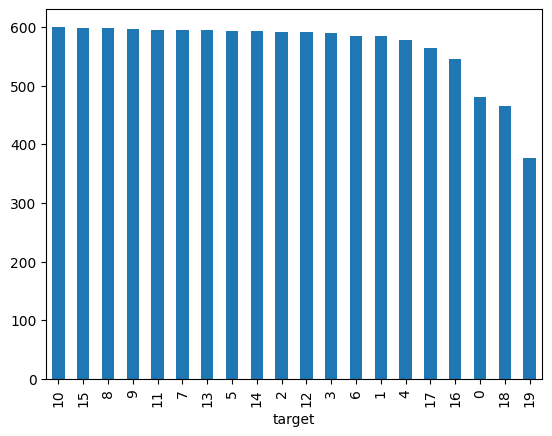

In [14]:
#레이블 값의 분포를 확인해보자

data['target'].value_counts().plot(kind='bar');

In [15]:
#구체적으로 확인

print(data.groupby('target').size().reset_index(name='count'))

    target  count
0        0    480
1        1    584
2        2    591
3        3    590
4        4    578
5        5    593
6        6    585
7        7    594
8        8    598
9        9    597
10      10    600
11      11    595
12      12    591
13      13    594
14      14    593
15      15    599
16      16    546
17      17    564
18      18    465
19      19    377


### 2.데이터 분리

In [16]:
newsdata_test=fetch_20newsgroups(subset='test', shuffle=True)

train_email=data['email']
train_label=data['target']
test_email=newsdata_test.data
test_label=newsdata_test.target

### 3.전처리

#### texts_to_matrix() 공부 쪼꼼 하고 가자
*  texts_to_matrix는 입력된 텍스트 데이터로부터 행렬을 만드는 도구이다.
* 4개의 모드를 지원하고 'binary', 'count', 'freq', 'tfidf' 총 4개 지원한다
  * (단어에 부여되는 인덱스는 1부터 시작하는 반면에 완성되는 행렬의 인덱스는 0부터 시작!!)
  * count : 문서 단어 행렬(dtm) 생성
  * binary : dtm과 비슷하지만 갯수 고려 안함
  * tfidf : tf-idf 행렬을 만듦.
  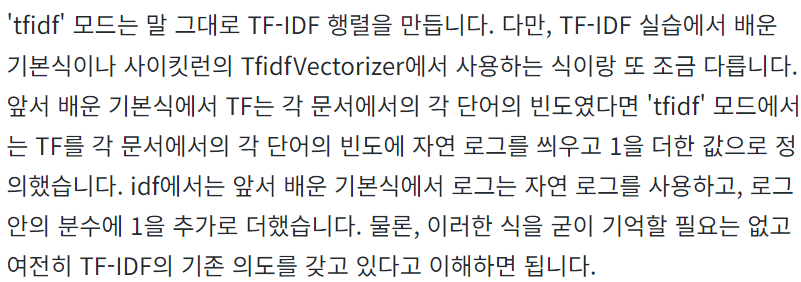
  * freq : 각 문서에서의 각 단어의 등장 횟수를 분자로, 각 문서의 크기를 분모로 하는 표현방법. 예를 들자면, '길고 노란 바나나 바나나' 에서 문서의 크기는 4, 바나나 횟수는 2 -> 0.5 의 값을 가짐

In [20]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer

texts = ['먹고 싶은 사과', '먹고 싶은 바나나', '길고 노란 바나나 바나나', '저는 과일이 좋아요']

tokenizer = Tokenizer() #토큰화 객체 생성
tokenizer.fit_on_texts(texts) #텍스트 토큰화 진행 (쩡수인코딩)
print(tokenizer.word_index)
print('\n', '*텍스트 데이터에 texts_to_matrix() 사용해보자*', '\n')
print(tokenizer.texts_to_matrix(texts, mode = 'count')) # texts_to_matrix의 입력으로 texts를 넣고, 모드는 'count'
print()
print(tokenizer.texts_to_matrix(texts, mode = 'binary'))
print()
print(tokenizer.texts_to_matrix(texts, mode = 'tfidf').round(2)) # 둘째 자리까지 반올림하여 출력
print()
print(tokenizer.texts_to_matrix(texts, mode = 'freq').round(2)) # 둘째 자리까지 반올림하여 출력

{'바나나': 1, '먹고': 2, '싶은': 3, '사과': 4, '길고': 5, '노란': 6, '저는': 7, '과일이': 8, '좋아요': 9}

 *텍스트 데이터에 texts_to_matrix() 사용해보자* 

[[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]

[[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]

[[0.   0.   0.85 0.85 1.1  0.   0.   0.   0.   0.  ]
 [0.   0.85 0.85 0.85 0.   0.   0.   0.   0.   0.  ]
 [0.   1.43 0.   0.   0.   1.1  1.1  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.1  1.1  1.1 ]]

[[0.   0.   0.33 0.33 0.33 0.   0.   0.   0.   0.  ]
 [0.   0.33 0.33 0.33 0.   0.   0.   0.   0.   0.  ]
 [0.   0.5  0.   0.   0.   0.25 0.25 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.33 0.33 0.33]]


#### 토큰화 및 행렬 생성

In [17]:
vocab_size=10000 #최대 단어 개수
num_classes=20

In [21]:
#text data 토큰화 -> train data, test data
# texts_to_matrix()를 사용하여 훈련데이터와 테스트데이터를 'binary', 'count', 'tfidf', 'freq' 4개의 모드 중 'binary'로 변환

def prepare_data(train_data, test_data, mode):
  tokenizer=Tokenizer(num_words=vocab_size)
  tokenizer.fit_on_texts(train_data)
  X_train=tokenizer.texts_to_matrix(train_data, mode=mode) # 샘플 수 × vocab_size 크기의 행렬 생성
  X_test=tokenizer.texts_to_matrix(test_data, mode=mode) # 샘플 수 × vocab_size 크기의 행렬 생성

  return X_train, X_test, tokenizer.index_word

In [22]:
X_train, X_test, index_to_word = prepare_data(train_email, test_email, 'binary') # binary 모드로 변환
y_train = to_categorical(train_label, num_classes) # 원-핫 인코딩
y_test = to_categorical(test_label, num_classes) # 원-핫 인코딩

In [23]:
print('훈련 샘플 본문의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 본문의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 본문의 크기 : (11314, 10000)
훈련 샘플 레이블의 크기 : (11314, 20)
테스트 샘플 본문의 크기 : (7532, 10000)
테스트 샘플 레이블의 크기 : (7532, 20)


In [24]:
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[1]))
print('빈도수 상위 9999번 단어 : {}'.format(index_to_word[9999]))

빈도수 상위 1번 단어 : the
빈도수 상위 9999번 단어 : mic


### 4.모델 생성

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [26]:
#다층 퍼셉트론 설계!!!! 다중 클래스 분류!!!!

def fit_and_evaluate(X_train, y_train, X_test, y_test):
  model=Sequential()
  model.add(Dense(256, input_shape=(vocab_size,), activation='relu')) #256개의 뉴런을 가진 은닉층
  model.add(Dropout(0.5)) #드롭아웃층
  model.add(Dense(128, activation='relu')) #128개의 뉴런을 가진 은닉층
  model.add(Dropout(0.5)) #드롭아웃층
  model.add(Dense(num_classes, activation='softmax')) #출력층 num_classes=20임

  #손실함수는 교차엔트로피, optimizer는 adam, 평가지표(metrics)는 정확도
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  #verbose=1이 default, 0으로 설정하면 훈련과정이 나오지 않고 1은 나옴.
  #validation_split으로 검증셋 설정
  model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.1)
  score=model.evaluate(X_test, y_test, batch_size=128, verbose=0)

  return score[1]


In [27]:
modes = ['binary', 'count', 'tfidf', 'freq'] # 4개의 모드를 리스트에 저장.

for mode in modes: # 4개의 모드에 대해서 모델 돌려보고 정확도 출력해보장장장
    X_train, X_test, _ = prepare_data(train_email, test_email, mode) # 모드에 따라서 데이터를 전처리
    score = fit_and_evaluate(X_train, y_train, X_test, y_test) # 모델을 훈련 및 평가
    print(mode+' 모드의 테스트 정확도:', score)

Epoch 1/5
80/80 [==============================] - 5s 53ms/step - loss: 2.2889 - accuracy: 0.3330 - val_loss: 0.9814 - val_accuracy: 0.8189
Epoch 2/5
80/80 [==============================] - 8s 102ms/step - loss: 0.8737 - accuracy: 0.7662 - val_loss: 0.4558 - val_accuracy: 0.8922
Epoch 3/5
80/80 [==============================] - 4s 56ms/step - loss: 0.4318 - accuracy: 0.8878 - val_loss: 0.3447 - val_accuracy: 0.9046
Epoch 4/5
80/80 [==============================] - 4s 48ms/step - loss: 0.2563 - accuracy: 0.9343 - val_loss: 0.3071 - val_accuracy: 0.9152
Epoch 5/5
80/80 [==============================] - 5s 66ms/step - loss: 0.1745 - accuracy: 0.9568 - val_loss: 0.2982 - val_accuracy: 0.9152
binary 모드의 테스트 정확도: 0.8291290402412415
Epoch 1/5
80/80 [==============================] - 5s 54ms/step - loss: 2.7373 - accuracy: 0.2476 - val_loss: 1.5915 - val_accuracy: 0.7412
Epoch 2/5
80/80 [==============================] - 4s 50ms/step - loss: 1.4232 - accuracy: 0.6287 - val_loss: 0.6963 - v

## 정리
* 데이터를 토큰화 -> 행렬 -> 모델 -> 정확도
* 은닉층은 2개 쌓고 드롭아웃층도 2개 쌓음
* 최종적으로 freq 모드 제외한 3개의 모드에서 정확도가 높게 나옴